In [1]:
import re
import nltk

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
nltk.download('punkt')

D:\Conda\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package punkt to D:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 1. Классификация фамилий (RNN)

Датасет: https://disk.yandex.ru/d/frNchuaBQVLxyA?w=1

1.1 Используя класс `nn.RNNCell` (абстракцию для отдельного временного шага RNN), реализуйте простейшую рекуррентную сеть Элмана в виде класса `RNN`. Используя созданный класс `RNN`, решите задачу классификации фамилий. 


In [2]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [61]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, vocab_size, embedding_size):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.rnn_cell = nn.RNNCell(embedding_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h=None):
        x = self.embedding(x)
        
        seq_len = x.size(1)
        batch_size = x.size(0)

        if h is None:
            h = torch.zeros(batch_size, self.rnn_cell.hidden_size, dtype=x.dtype, device=x.device)

        hidden_states = []
        for t in range(seq_len):
            h = self.rnn_cell(x[:, t, :], h)
            hidden_states.append(h)

        hidden_states = torch.stack(hidden_states, dim=1)
        output = self.fc(hidden_states[:, -1, :].squeeze(dim=1))
        return output

In [62]:
class Vocab:
    def __init__(self, data):
        self.char_to_index = {char: idx + 1 for idx, char in enumerate(set(' '.join(data['surname'])))}
        self.char_to_index['<PAD>'] = 0
        self.index_to_char = {idx: char for char, idx in self.char_to_index.items()}
        self.max_seq_len = max(data['surname'].apply(len))


class SurnamesDataset(Dataset):
    def __init__(self, data, vocab):
        self.data = data
        self.vocab = vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        surname = self.data.iloc[idx]['surname']
        nationality = self.data.iloc[idx]['nationality']
        
        indexed_sequence = [vocab.char_to_index[char] for char in surname]
        indexed_sequence += [vocab.char_to_index['<PAD>']] * (vocab.max_seq_len - len(surname))
        
        indexed_sequence = indexed_sequence[:vocab.max_seq_len]
        
        return torch.tensor(indexed_sequence), torch.tensor(nationality, dtype=torch.long)

In [63]:
data = pd.read_csv("surnames/surnames.csv")
class_mapping = {nationality: idx for idx, nationality in enumerate(data['nationality'].unique())}
data['nationality'] = data['nationality'].map(class_mapping)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [64]:
vocab = Vocab(data)
train_dataset = SurnamesDataset(train_data, vocab)
test_dataset = SurnamesDataset(test_data, vocab)

In [43]:
def train_model(model, train_loader, criterion, optimizer, num_epochs, test_loader=None):
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        if test_loader is not None:
            avg_test_loss = test_model(model, test_loader, criterion)
            test_losses.append(avg_test_loss)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

    return train_losses, test_losses

def test_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    avg_test_loss = running_loss / len(test_loader)
    return avg_test_loss

In [66]:
vocab_size = len(vocab.char_to_index)
hidden_size = 128
embedding_size = 10
output_size = len(class_mapping)

model = RNN(input_size=vocab_size, hidden_size=hidden_size, output_size=output_size, vocab_size=vocab_size, embedding_size=embedding_size)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64

num_epochs = 25

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_losses, test_losses = train_model(model, train_dataloader, criterion, optimizer, num_epochs, test_dataloader)

Epoch [1/25], Train Loss: 2.2630, Test Loss: 2.2295
Epoch [2/25], Train Loss: 2.2309, Test Loss: 2.2258
Epoch [3/25], Train Loss: 2.1979, Test Loss: 2.1425
Epoch [4/25], Train Loss: 2.0600, Test Loss: 2.0145
Epoch [5/25], Train Loss: 1.9642, Test Loss: 1.9234
Epoch [6/25], Train Loss: 1.8956, Test Loss: 1.8667
Epoch [7/25], Train Loss: 1.7993, Test Loss: 1.8142
Epoch [8/25], Train Loss: 1.7342, Test Loss: 1.7719
Epoch [9/25], Train Loss: 1.6729, Test Loss: 1.6941
Epoch [10/25], Train Loss: 1.5821, Test Loss: 1.5641
Epoch [11/25], Train Loss: 1.5230, Test Loss: 1.5190
Epoch [12/25], Train Loss: 1.4527, Test Loss: 1.4598
Epoch [13/25], Train Loss: 1.3853, Test Loss: 1.5133
Epoch [14/25], Train Loss: 1.3474, Test Loss: 1.3842
Epoch [15/25], Train Loss: 1.2868, Test Loss: 1.3423
Epoch [16/25], Train Loss: 1.2491, Test Loss: 1.3607
Epoch [17/25], Train Loss: 1.2069, Test Loss: 1.2401
Epoch [18/25], Train Loss: 1.1799, Test Loss: 1.2217
Epoch [19/25], Train Loss: 1.1333, Test Loss: 1.2355
Ep

In [67]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy RNNCell: {accuracy * 100:.2f}%')

Test Accuracy RNNCell: 66.62%


In [68]:
def plot_confusion_matrix(model, test_loader, class_mapping):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.tolist())
            all_predictions.extend(predicted.tolist())

    cm = confusion_matrix(all_labels, all_predictions)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_mapping.keys(), yticklabels=class_mapping.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

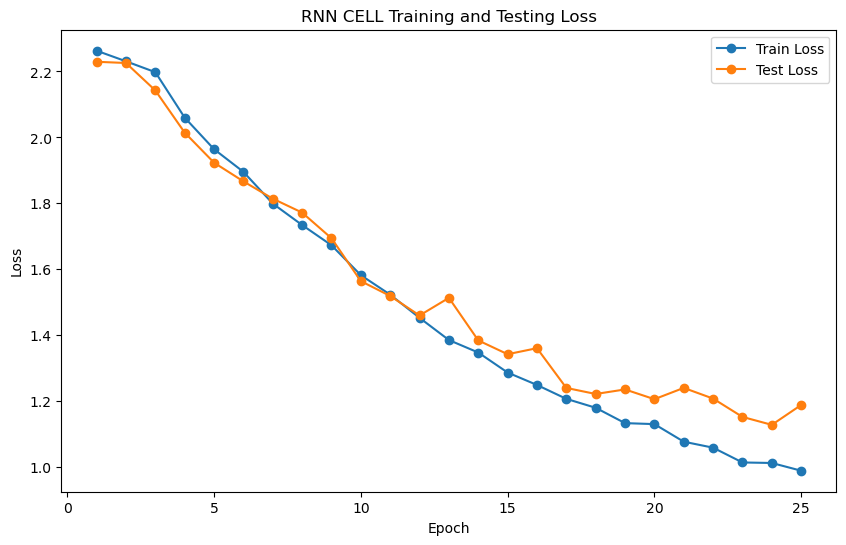

In [75]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', marker='o')
plt.title('RNN CELL Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

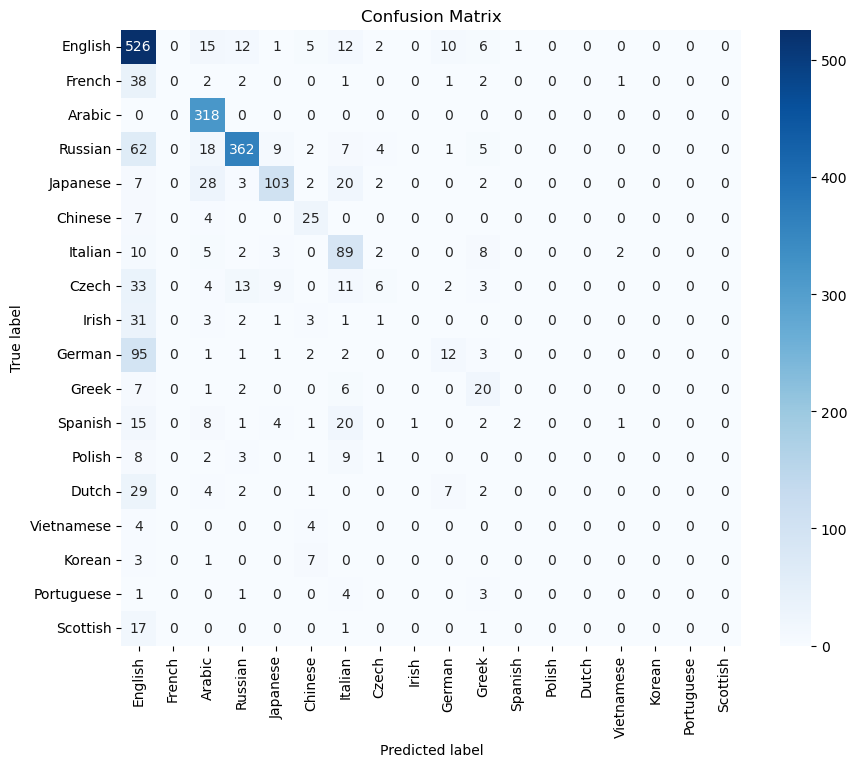

In [70]:
plot_confusion_matrix(model, test_dataloader, class_mapping)

1.2 Замените модуль `RNN` из 1.1 на модули `nn.RNN`, `nn.LSTM` и `nn.GRU` (не забудьте указать аргумент `batch_first=True`). Сравните результаты работы.

In [71]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, vocab_size, embedding_size, rnn_type='rnn'):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        
        if rnn_type == 'rnn':
            self.rnn = nn.RNN(input_size=embedding_size, hidden_size=hidden_size, batch_first=True)
        elif rnn_type == 'lstm':
            self.rnn = nn.LSTM(input_size=embedding_size, hidden_size=hidden_size, batch_first=True)
        elif rnn_type == 'gru':
            self.rnn = nn.GRU(input_size=embedding_size, hidden_size=hidden_size, batch_first=True)
        else:
            raise ValueError("Invalid rnn_type. Use 'rnn', 'lstm', or 'gru'.")

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.rnn(x)
        output = self.fc(output[:, -1, :])
        return output


### `nn.RNN`

In [72]:
vocab_size = len(vocab.char_to_index)
hidden_size = 128
embedding_size = 10
output_size = len(class_mapping)

model_rnn = RNN(input_size=embedding_size, hidden_size=hidden_size, output_size=output_size, vocab_size=vocab_size, embedding_size=embedding_size, rnn_type='rnn')

criterion = nn.CrossEntropyLoss()
optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=0.001)

batch_size = 64

num_epochs = 25

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_losses_rnn, test_losses_rnn = train_model(model_rnn, train_dataloader, criterion, optimizer_rnn, num_epochs, test_dataloader)

Epoch [1/25], Train Loss: 2.2629, Test Loss: 2.2298
Epoch [2/25], Train Loss: 2.2318, Test Loss: 2.2332
Epoch [3/25], Train Loss: 2.1799, Test Loss: 2.1107
Epoch [4/25], Train Loss: 2.0420, Test Loss: 2.0441
Epoch [5/25], Train Loss: 1.9553, Test Loss: 1.9517
Epoch [6/25], Train Loss: 1.8896, Test Loss: 1.9161
Epoch [7/25], Train Loss: 1.8449, Test Loss: 1.8361
Epoch [8/25], Train Loss: 1.7799, Test Loss: 1.8163
Epoch [9/25], Train Loss: 1.7299, Test Loss: 1.7220
Epoch [10/25], Train Loss: 1.6788, Test Loss: 1.6621
Epoch [11/25], Train Loss: 1.6067, Test Loss: 1.6664
Epoch [12/25], Train Loss: 1.5639, Test Loss: 1.6016
Epoch [13/25], Train Loss: 1.5043, Test Loss: 1.5822
Epoch [14/25], Train Loss: 1.4272, Test Loss: 1.4404
Epoch [15/25], Train Loss: 1.3830, Test Loss: 1.4157
Epoch [16/25], Train Loss: 1.3316, Test Loss: 1.3758
Epoch [17/25], Train Loss: 1.2890, Test Loss: 1.3269
Epoch [18/25], Train Loss: 1.2216, Test Loss: 1.3349
Epoch [19/25], Train Loss: 1.2002, Test Loss: 1.3990
Ep

In [76]:
model_rnn.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model_rnn(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy RNN: {accuracy * 100:.2f}%')

Test Accuracy RNN: 66.12%


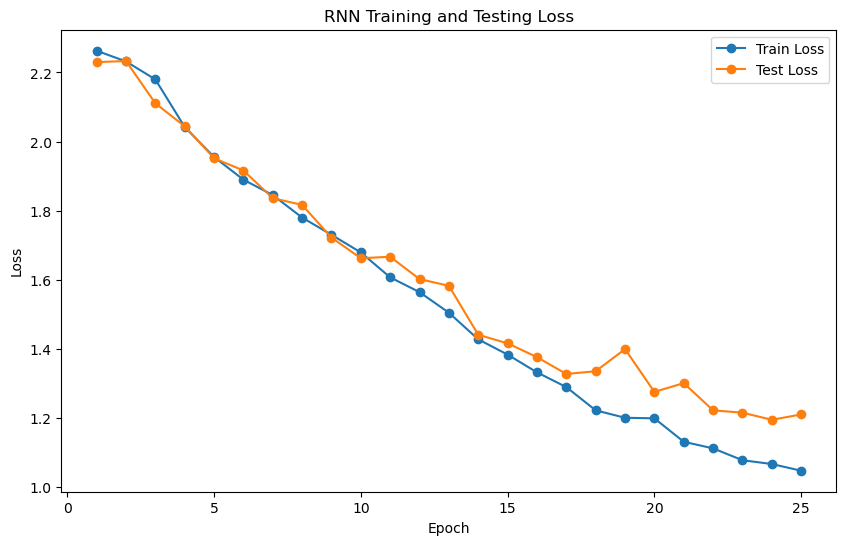

In [77]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses_rnn, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), test_losses_rnn, label='Test Loss', marker='o')
plt.title('RNN Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### `nn.LSTM`

In [78]:
vocab_size = len(vocab.char_to_index)
hidden_size = 128
embedding_size = 10
output_size = len(class_mapping)

model_lstm = RNN(input_size=embedding_size, hidden_size=hidden_size, output_size=output_size, vocab_size=vocab_size, embedding_size=embedding_size, rnn_type='lstm')

criterion = nn.CrossEntropyLoss()
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=0.001)

batch_size = 64

num_epochs = 25

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_losses_lstm, test_losses_lstm = train_model(model_lstm, train_dataloader, criterion, optimizer_lstm, num_epochs, test_dataloader)

Epoch [1/25], Train Loss: 2.2673, Test Loss: 2.1159
Epoch [2/25], Train Loss: 1.9739, Test Loss: 1.9236
Epoch [3/25], Train Loss: 1.8406, Test Loss: 1.8030
Epoch [4/25], Train Loss: 1.7401, Test Loss: 1.6855
Epoch [5/25], Train Loss: 1.5823, Test Loss: 1.5068
Epoch [6/25], Train Loss: 1.4284, Test Loss: 1.3782
Epoch [7/25], Train Loss: 1.3142, Test Loss: 1.2976
Epoch [8/25], Train Loss: 1.2228, Test Loss: 1.2933
Epoch [9/25], Train Loss: 1.1586, Test Loss: 1.2412
Epoch [10/25], Train Loss: 1.0942, Test Loss: 1.1545
Epoch [11/25], Train Loss: 1.0376, Test Loss: 1.0963
Epoch [12/25], Train Loss: 0.9882, Test Loss: 1.1605
Epoch [13/25], Train Loss: 0.9647, Test Loss: 1.0460
Epoch [14/25], Train Loss: 0.9169, Test Loss: 1.0596
Epoch [15/25], Train Loss: 0.8876, Test Loss: 1.0345
Epoch [16/25], Train Loss: 0.8684, Test Loss: 1.0277
Epoch [17/25], Train Loss: 0.8318, Test Loss: 0.9923
Epoch [18/25], Train Loss: 0.8152, Test Loss: 0.9789
Epoch [19/25], Train Loss: 0.7898, Test Loss: 0.9968
Ep

In [80]:
model_lstm.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model_lstm(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy LSTM: {accuracy * 100:.2f}%')

Test Accuracy LSTM: 73.09%


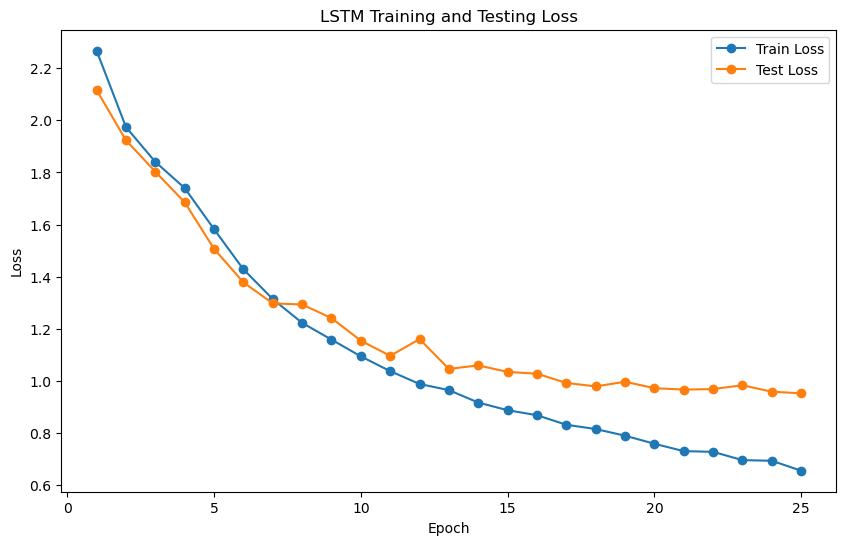

In [81]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses_lstm, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), test_losses_lstm, label='Test Loss', marker='o')
plt.title('LSTM Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### `nn.GRU`

In [90]:
vocab_size = len(vocab.char_to_index)
hidden_size = 128
embedding_size = 10
output_size = len(class_mapping)

model_gru = RNN(input_size=embedding_size, hidden_size=hidden_size, output_size=output_size, vocab_size=vocab_size, embedding_size=embedding_size, rnn_type='gru')

criterion = nn.CrossEntropyLoss()
optimizer_gru = torch.optim.Adam(model_gru.parameters(), lr=0.001)

batch_size = 64

num_epochs = 25

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_losses_gru, test_losses_gru = train_model(model_gru, train_dataloader, criterion, optimizer_gru, num_epochs, test_dataloader)

Epoch [1/25], Train Loss: 2.2037, Test Loss: 2.0244
Epoch [2/25], Train Loss: 1.8077, Test Loss: 1.6883
Epoch [3/25], Train Loss: 1.5256, Test Loss: 1.4593
Epoch [4/25], Train Loss: 1.3434, Test Loss: 1.3385
Epoch [5/25], Train Loss: 1.2197, Test Loss: 1.2284
Epoch [6/25], Train Loss: 1.1210, Test Loss: 1.1760
Epoch [7/25], Train Loss: 1.0442, Test Loss: 1.1294
Epoch [8/25], Train Loss: 0.9821, Test Loss: 1.0578
Epoch [9/25], Train Loss: 0.9416, Test Loss: 1.0313
Epoch [10/25], Train Loss: 0.8991, Test Loss: 0.9768
Epoch [11/25], Train Loss: 0.8613, Test Loss: 0.9489
Epoch [12/25], Train Loss: 0.8179, Test Loss: 0.9672
Epoch [13/25], Train Loss: 0.7805, Test Loss: 0.9183
Epoch [14/25], Train Loss: 0.7493, Test Loss: 0.9264
Epoch [15/25], Train Loss: 0.7269, Test Loss: 0.9024
Epoch [16/25], Train Loss: 0.6922, Test Loss: 0.9158
Epoch [17/25], Train Loss: 0.6683, Test Loss: 0.9404
Epoch [18/25], Train Loss: 0.6333, Test Loss: 0.9098
Epoch [19/25], Train Loss: 0.5982, Test Loss: 0.9187
Ep

In [91]:
model_gru.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model_gru(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy GRU: {accuracy * 100:.2f}%')

Test Accuracy GRU: 75.05%


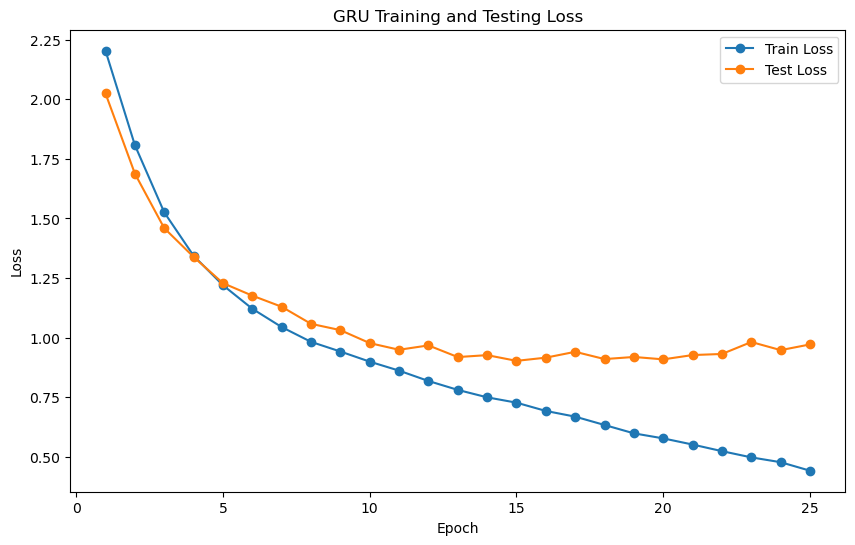

In [93]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses_gru, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), test_losses_gru, label='Test Loss', marker='o')
plt.title('GRU Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Вывод:
Модель `nn.RNN` имеет сравнимый результат с моделью `nn.RNNCell` из задачи `1.1` (около 66-67 процентов точности). `nn.GRU` имеет наивысший результат - 75% точности, `nn.LSTM` имеет результат чуть ниже, около 73%, но при это существенно выше по сравнению с `nn.RNN` и `nn.RNNCell`.  

1.3 Загрузите предобученные эмбеддинги (https://disk.yandex.ru/d/BHuT2tEXr_yBOQ?w=1) в модуль `nn.Embedding` и обучите модели из 1.2.

### `nn.RNN` с предобученными эмбеддингами

In [94]:
def load_pretrained_embeddings(embedding_layer, embedding_file_path, char_to_index):
    with open(embedding_file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    word_to_vector = {}
    for line in lines:
        values = line.split()
        word = values[0]
        vector = torch.tensor([float(val) for val in values[1:]])
        word_to_vector[word] = vector

    for char, index in char_to_index.items():
        if char in word_to_vector:
            embedding_layer.weight.data[index] = word_to_vector[char]

In [98]:
vocab_size = len(vocab.char_to_index)
embedding_size = 50
hidden_size = 128
output_size = len(class_mapping)
rnn_type = 'rnn'

glove_path = 'glove.6B.50d.txt'

model_rnn_emb = RNN(input_size=embedding_size, hidden_size=hidden_size, output_size=output_size, vocab_size=vocab_size, embedding_size=embedding_size, rnn_type=rnn_type)

load_pretrained_embeddings(model_rnn_emb.embedding, glove_path, vocab.char_to_index)

criterion = nn.CrossEntropyLoss()
optimizer_rnn_emb = torch.optim.Adam(model_rnn_emb.parameters(), lr=0.001)

batch_size = 64

num_epochs = 25

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_losses_rnn_emb, test_losses_rnn_emb = train_model(model_rnn_emb, train_dataloader, criterion, optimizer_rnn_emb, num_epochs, test_dataloader)

Epoch [1/25], Train Loss: 2.2441, Test Loss: 2.2355
Epoch [2/25], Train Loss: 2.2350, Test Loss: 2.2258
Epoch [3/25], Train Loss: 2.1261, Test Loss: 2.1047
Epoch [4/25], Train Loss: 2.0029, Test Loss: 1.9626
Epoch [5/25], Train Loss: 1.8830, Test Loss: 1.8515
Epoch [6/25], Train Loss: 1.7843, Test Loss: 1.7556
Epoch [7/25], Train Loss: 1.7170, Test Loss: 1.7498
Epoch [8/25], Train Loss: 1.6771, Test Loss: 1.7107
Epoch [9/25], Train Loss: 1.5689, Test Loss: 1.5775
Epoch [10/25], Train Loss: 1.4986, Test Loss: 1.5561
Epoch [11/25], Train Loss: 1.4332, Test Loss: 1.4519
Epoch [12/25], Train Loss: 1.3679, Test Loss: 1.4453
Epoch [13/25], Train Loss: 1.3388, Test Loss: 1.3819
Epoch [14/25], Train Loss: 1.2989, Test Loss: 1.3444
Epoch [15/25], Train Loss: 1.2607, Test Loss: 1.3467
Epoch [16/25], Train Loss: 1.2066, Test Loss: 1.3629
Epoch [17/25], Train Loss: 1.1962, Test Loss: 1.2952
Epoch [18/25], Train Loss: 1.1573, Test Loss: 1.3390
Epoch [19/25], Train Loss: 1.1383, Test Loss: 1.1943
Ep

In [100]:
model_rnn_emb.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model_rnn_emb(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy RNN: {accuracy * 100:.2f}%')

Test Accuracy RNN: 67.17%


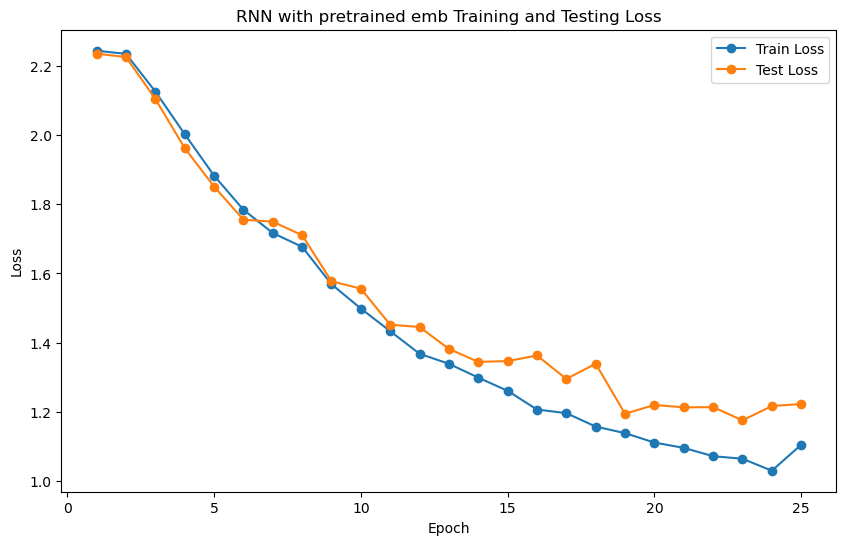

In [101]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses_rnn_emb, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), test_losses_rnn_emb, label='Test Loss', marker='o')
plt.title('RNN with pretrained emb Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### `nn.LSTM` с предобученными эмбеддингами

In [102]:
vocab_size = len(vocab.char_to_index)
embedding_size = 50
hidden_size = 128
output_size = len(class_mapping)
rnn_type = 'lstm'

glove_path = 'glove.6B.50d.txt'

model_lstm_emb = RNN(input_size=embedding_size, hidden_size=hidden_size, output_size=output_size, vocab_size=vocab_size, embedding_size=embedding_size, rnn_type=rnn_type)

load_pretrained_embeddings(model_lstm_emb.embedding, glove_path, vocab.char_to_index)

criterion = nn.CrossEntropyLoss()
optimizer_lstm_emb = torch.optim.Adam(model_lstm_emb.parameters(), lr=0.001)

batch_size = 64

num_epochs = 25

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_losses_lstm_emb, test_losses_lstm_emb = train_model(model_lstm_emb, train_dataloader, criterion, optimizer_lstm_emb, num_epochs, test_dataloader)

Epoch [1/25], Train Loss: 2.1405, Test Loss: 1.9285
Epoch [2/25], Train Loss: 1.7945, Test Loss: 1.6682
Epoch [3/25], Train Loss: 1.5286, Test Loss: 1.4680
Epoch [4/25], Train Loss: 1.3841, Test Loss: 1.4034
Epoch [5/25], Train Loss: 1.2689, Test Loss: 1.2577
Epoch [6/25], Train Loss: 1.1232, Test Loss: 1.1830
Epoch [7/25], Train Loss: 1.0522, Test Loss: 1.0595
Epoch [8/25], Train Loss: 0.9635, Test Loss: 1.0218
Epoch [9/25], Train Loss: 0.9018, Test Loss: 1.0024
Epoch [10/25], Train Loss: 0.8654, Test Loss: 0.9729
Epoch [11/25], Train Loss: 0.8011, Test Loss: 0.9342
Epoch [12/25], Train Loss: 0.7561, Test Loss: 0.9213
Epoch [13/25], Train Loss: 0.7104, Test Loss: 0.9189
Epoch [14/25], Train Loss: 0.6866, Test Loss: 0.8892
Epoch [15/25], Train Loss: 0.6549, Test Loss: 0.8766
Epoch [16/25], Train Loss: 0.6185, Test Loss: 0.8808
Epoch [17/25], Train Loss: 0.5877, Test Loss: 0.8833
Epoch [18/25], Train Loss: 0.5474, Test Loss: 0.8689
Epoch [19/25], Train Loss: 0.5382, Test Loss: 0.8692
Ep

In [103]:
model_lstm_emb.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model_lstm_emb(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy LSTM: {accuracy * 100:.2f}%')

Test Accuracy LSTM: 74.86%


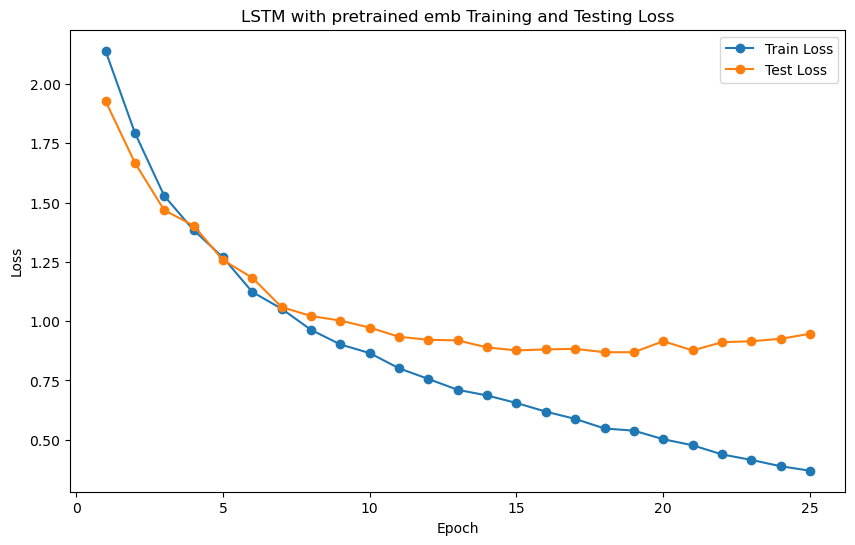

In [104]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses_lstm_emb, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), test_losses_lstm_emb, label='Test Loss', marker='o')
plt.title('LSTM with pretrained emb Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### `nn.GRU` с предобученными эмбеддингами

In [109]:
vocab_size = len(vocab.char_to_index)
embedding_size = 50
hidden_size = 128
output_size = len(class_mapping)
rnn_type = 'gru'

glove_path = 'glove.6B.50d.txt'

model_gru_emb = RNN(input_size=embedding_size, hidden_size=hidden_size, output_size=output_size, vocab_size=vocab_size, embedding_size=embedding_size, rnn_type=rnn_type)

load_pretrained_embeddings(model_gru_emb.embedding, glove_path, vocab.char_to_index)

criterion = nn.CrossEntropyLoss()
optimizer_gru_emb = torch.optim.Adam(model_gru_emb.parameters(), lr=0.001)

batch_size = 64

num_epochs = 13

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_losses_gru_emb, test_losses_gru_emb = train_model(model_gru_emb, train_dataloader, criterion, optimizer_gru_emb, num_epochs, test_dataloader)

Epoch [1/13], Train Loss: 2.0729, Test Loss: 1.7724
Epoch [2/13], Train Loss: 1.5682, Test Loss: 1.4507
Epoch [3/13], Train Loss: 1.3296, Test Loss: 1.2951
Epoch [4/13], Train Loss: 1.1455, Test Loss: 1.1694
Epoch [5/13], Train Loss: 1.0107, Test Loss: 1.0451
Epoch [6/13], Train Loss: 0.9294, Test Loss: 1.0488
Epoch [7/13], Train Loss: 0.8737, Test Loss: 0.9495
Epoch [8/13], Train Loss: 0.8069, Test Loss: 0.9177
Epoch [9/13], Train Loss: 0.7574, Test Loss: 0.9569
Epoch [10/13], Train Loss: 0.7216, Test Loss: 0.8901
Epoch [11/13], Train Loss: 0.6750, Test Loss: 0.9147
Epoch [12/13], Train Loss: 0.6425, Test Loss: 0.8798
Epoch [13/13], Train Loss: 0.6051, Test Loss: 0.8518


In [110]:
model_gru_emb.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model_gru_emb(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy GRU: {accuracy * 100:.2f}%')

Test Accuracy GRU: 76.46%


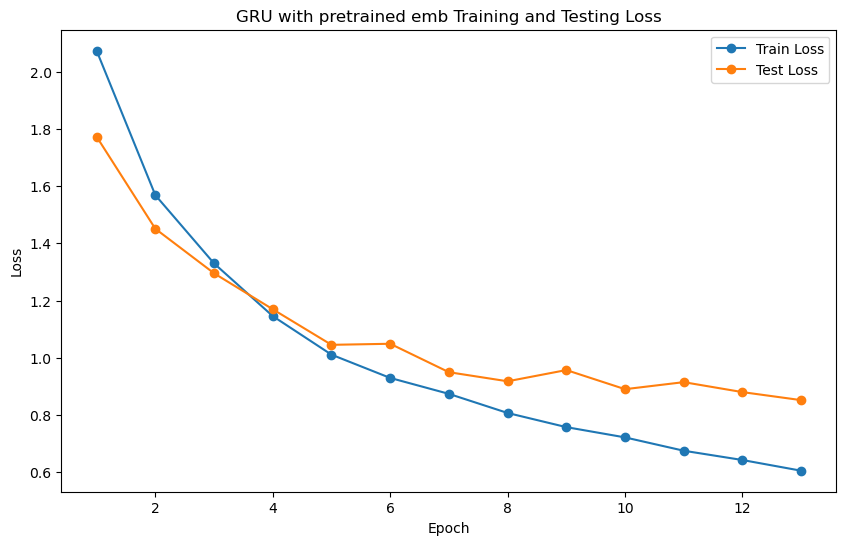

In [111]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses_gru_emb, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), test_losses_gru_emb, label='Test Loss', marker='o')
plt.title('GRU with pretrained emb Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Вывод:
Резульаты всех моделей стали незначительно лучше (на 1-2 процента) после применения предобученных эмбеддингов.

# -----------------------------------------------------------------------------------------------------------------

## 2. Классификация обзоров на фильмы (RNN)

Датасет: https://disk.yandex.ru/d/tdinpb0nN_Dsrg

2.1 Создайте набор данных на основе файлов polarity/positive_reviews.csv (положительные отзывы) и polarity/negative_reviews.csv (отрицательные отзывы). Разбейте на обучающую и тестовую выборку.
  * токен = __слово__
  * данные для обучения в датасете представляются в виде последовательности индексов токенов
  * словарь создается на основе _только_ обучающей выборки. Для корректной обработки ситуаций, когда в тестовой выборке встретится токен, который не хранится в словаре, добавьте в словарь специальный токен `<UNK>`
  * добавьте предобработку текста

2.2. Обучите классификатор.
  
  * Для преобразования последовательности индексов в последовательность векторов используйте `nn.Embedding` 
    - подберите адекватную размерность вектора эмбеддинга: 
    - модуль `nn.Embedding` обучается

  * Используйте рекуррентные слои (`nn.RNN`, `nn.LSTM`, `nn.GRU`)


2.3 Измерить точность на тестовой выборке. Проверить работоспособность модели: придумать небольшой отзыв, прогнать его через модель и вывести номер предсказанного класса (сделать это для явно позитивного и явно негативного отзыва)
* Целевое значение accuracy на валидации - 70+%

In [27]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import string
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk import word_tokenize
from tqdm import tqdm

In [5]:
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = f.readlines()
    return data

def preprocess_text(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

In [6]:
def build_vocab(data):
    vocab = {'<PAD>': 0, '<UNK>': 1}  
    for text in data:
        tokens = preprocess_text(text)
        for token in tokens:
            if token not in vocab:
                vocab[token] = len(vocab)
    return vocab

In [7]:
class SentimentDataset(Dataset):
    def __init__(self, data, labels, vocab, max_seq_len):
        self.data = data
        self.labels = labels
        self.vocab = vocab
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx]
        label = self.labels[idx]

        tokens = preprocess_text(text)
        indices = [self.vocab.get(token, self.vocab['<UNK>']) for token in tokens]

        padded_indices = indices + [self.vocab['<PAD>']] * (self.max_seq_len - len(indices))
        return torch.tensor(padded_indices), torch.tensor(label)

In [40]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, vocab_size, embedding_size, rnn_type='rnn'):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        if rnn_type == 'rnn':
            self.rnn = nn.RNN(input_size=embedding_size, hidden_size=hidden_size, batch_first=True)
        elif rnn_type == 'lstm':
            self.rnn = nn.LSTM(input_size=embedding_size, hidden_size=hidden_size, batch_first=True)
        elif rnn_type == 'gru':
            self.rnn = nn.GRU(input_size=embedding_size, hidden_size=hidden_size, batch_first=True)
        else:
            raise ValueError("Invalid rnn_type. Use 'rnn', 'lstm', or 'gru'.")

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.rnn(x)
        output = self.fc(output[:, -1, :])
        return output


In [45]:
positive_data = load_data('positive_reviews.txt')
negative_data = load_data('negative_reviews.txt')

positive_df = pd.DataFrame({'text': positive_data, 'label': 1})
negative_df = pd.DataFrame({'text': negative_data, 'label': 0})

all_data_df = pd.concat([positive_df, negative_df], ignore_index=True)
shuffled_df = all_data_df.sample(frac=1, random_state=42).reset_index(drop=True)
train_df, test_df = train_test_split(shuffled_df, test_size=0.2, random_state=42)

vocab = build_vocab(train_df['text'].tolist())
batch_size = 64
max_seq_len_train = max(train_df['text'].apply(lambda text: len(preprocess_text(text))))

train_dataset = SentimentDataset(train_df['text'].tolist(), train_df['label'].tolist(), vocab, max_seq_len_train)
test_dataset = SentimentDataset(test_df['text'].tolist(), test_df['label'].tolist(), vocab, max_seq_len_train)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [55]:
# Обновим функцию обучения для сохранения наилучшей модели
def train_model(model, train_loader, criterion, optimizer, num_epochs, test_loader=None, save_path=None):
    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    best_epoch = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        if test_loader is not None:
            avg_test_loss = test_model(model, test_loader, criterion)
            test_losses.append(avg_test_loss)

            if avg_test_loss < best_test_loss:
                best_test_loss = avg_test_loss
                best_epoch = epoch
                if save_path:
                    torch.save(model.state_dict(), save_path)

            print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

    print(f'Best model saved after epoch {best_epoch + 1}, Test Loss: {best_test_loss:.4f}')

    return train_losses, test_losses

### `nn.GRU`

In [70]:
vocab_size = len(vocab)
embedding_size = 256
hidden_size = 128
output_size = 2
rnn_type = 'gru'

num_epochs = 10

model_gru = RNN(input_size=embedding_size, hidden_size=hidden_size, output_size=output_size, vocab_size=vocab_size, embedding_size=embedding_size, rnn_type=rnn_type)
criterion = nn.CrossEntropyLoss()
optimizer_gru = optim.Adam(model_gru.parameters(), lr=0.001)

train_losses_gru, test_losses_gru = train_model(model_gru, train_loader, criterion, optimizer_gru, num_epochs, test_loader, 'models/model.pt')

Epoch [1/10], Train Loss: 0.7027, Test Loss: 0.6897
Epoch [2/10], Train Loss: 0.6438, Test Loss: 0.6186
Epoch [3/10], Train Loss: 0.4177, Test Loss: 0.5709
Epoch [4/10], Train Loss: 0.1941, Test Loss: 0.7911
Epoch [5/10], Train Loss: 0.0822, Test Loss: 0.8307
Epoch [6/10], Train Loss: 0.0409, Test Loss: 1.1460
Epoch [7/10], Train Loss: 0.0248, Test Loss: 1.2411
Epoch [8/10], Train Loss: 0.0196, Test Loss: 1.3410
Epoch [9/10], Train Loss: 0.0162, Test Loss: 1.4769
Epoch [10/10], Train Loss: 0.0081, Test Loss: 1.4773
Best model saved after epoch 3, Test Loss: 0.5709


In [71]:
best_model_gru = RNN(input_size=embedding_size, hidden_size=hidden_size, output_size=output_size, vocab_size=vocab_size, embedding_size=embedding_size, rnn_type='gru')
best_model_gru.load_state_dict(torch.load('models/model.pt'))
best_model_gru.eval()

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = best_model_gru(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy BEST GRU: {accuracy * 100:.2f}%')

Test Accuracy BEST GRU: 71.96%


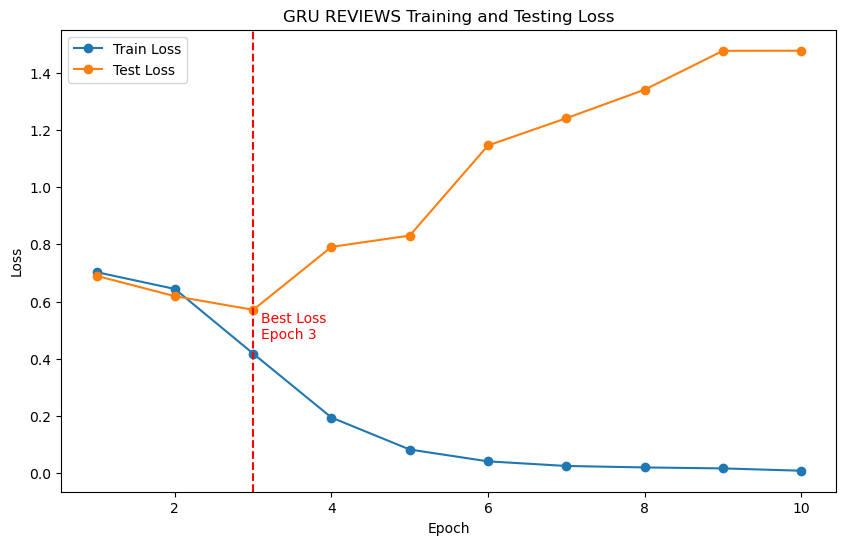

In [75]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses_gru, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), test_losses_gru, label='Test Loss', marker='o')
plt.title('GRU REVIEWS Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

best_epoch = test_losses_gru.index(min(test_losses_gru)) + 1

plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Test Loss')
plt.text(best_epoch + 0.1, min(test_losses_gru)-0.1, f'Best Loss\nEpoch {best_epoch}', color='r')
plt.show()

#### Проверка модели на своих отзывах

In [93]:
def preprocess_test_text(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

positive_review = "This is a great way to spend 2 hours with pleasure. Good cast and director's work. Well done!"
negative_review = "Too boring and dragged out, moreover - predictable ending. I do not recommend watching it. Bad movie!"

positive_indices = [vocab.get(token, vocab['<UNK>']) for token in preprocess_test_text(positive_review)]
negative_indices = [vocab.get(token, vocab['<UNK>']) for token in preprocess_test_text(negative_review)]

positive_tensor = torch.tensor(positive_indices).unsqueeze(0) 
negative_tensor = torch.tensor(negative_indices).unsqueeze(0)

best_model_gru.eval()

positive_predictions = best_model_gru(positive_tensor)
negative_predictions = best_model_gru(negative_tensor)

positive_probs = torch.softmax(positive_predictions, dim=1).squeeze().tolist()
negative_probs = torch.softmax(negative_predictions, dim=1).squeeze().tolist()

positive_label = 'Позитивный' if positive_probs[1] > positive_probs[0] else 'Негативный'
negative_label = 'Позитивный' if negative_probs[1] > negative_probs[0] else 'Негативный'
print('---Первый отзыв---')
print(f'Текст отзыва: {positive_review} \nПредсказание: {positive_label} \nВероятности: {positive_probs}\n')
print('---Второй отзыв---')
print(f'Текст отзыва: {negative_review} \nПредсказание: {negative_label} \nВероятности: {negative_probs}')

---Первый отзыв---
Текст отзыва: This is a great way to spend 2 hours with pleasure. Good cast and director's work. Well done! 
Предсказание: Позитивный 
Вероятности: [0.2558695077896118, 0.7441304326057434]

---Второй отзыв---
Текст отзыва: Too boring and dragged out, moreover - predictable ending. I do not recommend watching it. Bad movie! 
Предсказание: Негативный 
Вероятности: [0.9014339447021484, 0.09856611490249634]
